# Training a Tomato Classification Model
Classes are: Ripe, Rotten, Unripe and Not_tomato


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

## Setup Paths, Mount GDrive
Find the dataset, models etc

In [3]:
import os

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


In [0]:
_pwd = !pwd

In [31]:
_pwd[0]

'/content/gdrive/My Drive'

In [34]:
# Set the path where the datasets are
path_data = Path(_pwd[0]+'/datasets/tomato_classification'); path_data

PosixPath('/content/gdrive/My Drive/datasets/tomato_classification')

In [35]:
path_data.ls()

[PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/tomato_ripe'),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/tomato_rotten'),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/tomato_unripe'),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/not_tomato')]

In [36]:
# Path where trained models are saved etc
path_model = Path(_pwd[0]+'/models/tomato_classification'); path_model

PosixPath('/content/gdrive/My Drive/models/tomato_classification')

In [37]:
path_model.ls()

[PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet34_4epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet34_10epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/tmp.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet18_10epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet18_10_10epochs_err09.pth')]

## Create the ImageDataBunch object

In [0]:
bs = 32
np.random.seed(16)
data = ImageDataBunch.from_folder(path_data, valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [68]:
data

ImageDataBunch;

Train: LabelList (488 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tomato_ripe,tomato_ripe,tomato_ripe,tomato_ripe,tomato_ripe
Path: /content/gdrive/My Drive/datasets/tomato_classification;

Valid: LabelList (122 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
not_tomato,tomato_unripe,not_tomato,not_tomato,tomato_unripe
Path: /content/gdrive/My Drive/datasets/tomato_classification;

Test: None

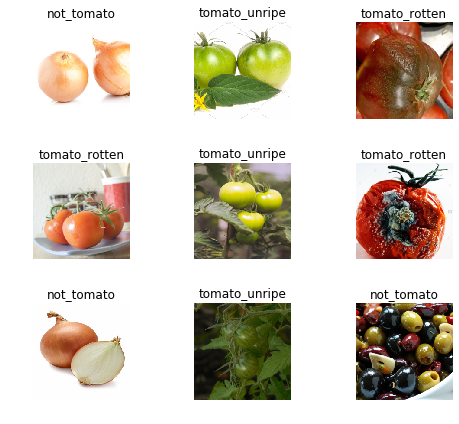

In [69]:
data.show_batch(rows=3, figsize=(7,6))

In [70]:
print(data.classes)
len(data.classes),data.c

['not_tomato', 'tomato_ripe', 'tomato_rotten', 'tomato_unripe']


(4, 4)

## Train

### Step 1: Create the Learner
Resnet18 based, with a standard head

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

In [0]:
learn.model

In [73]:
learn.loss_func, learn.path

(FlattenedLoss of CrossEntropyLoss(),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification'))

### Step 2: First training, and examination of results

In [74]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.582562,1.090641,0.459016,00:31
1,1.103274,0.619362,0.196721,00:30
2,0.812204,0.617888,0.204918,00:31
3,0.641942,0.599281,0.172131,00:29
4,0.520417,0.529092,0.172131,00:30
5,0.445138,0.541674,0.163934,00:30
6,0.374517,0.546763,0.172131,00:30
7,0.325775,0.563690,0.172131,00:30
8,0.285981,0.561926,0.155738,00:31
9,0.251227,0.556848,0.163934,00:30


In [0]:
learn.save(path_model/'rn18_stg1_1')

In [93]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

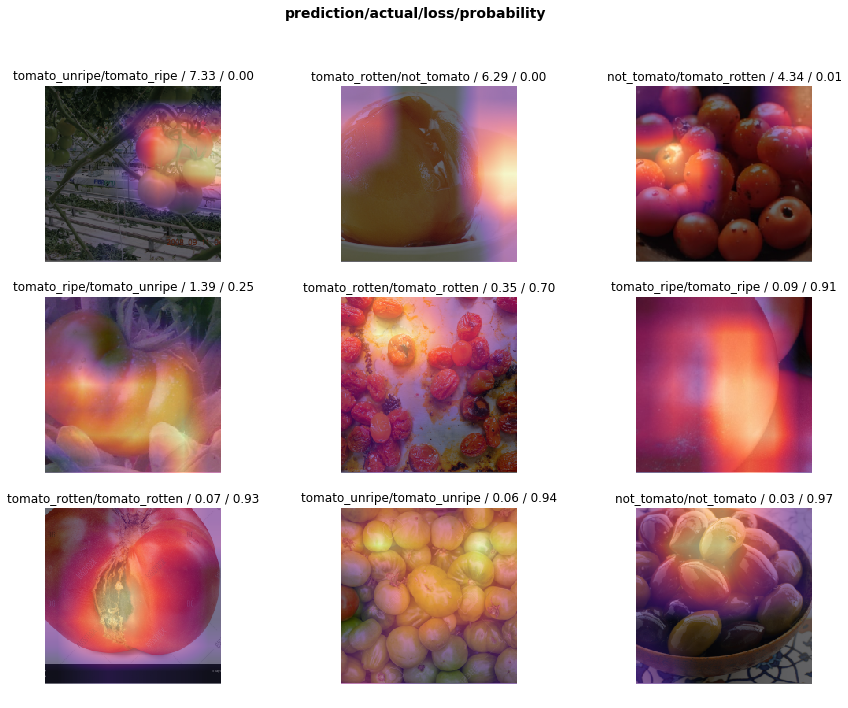

In [94]:
interp.plot_top_losses(9, figsize=(15,11))

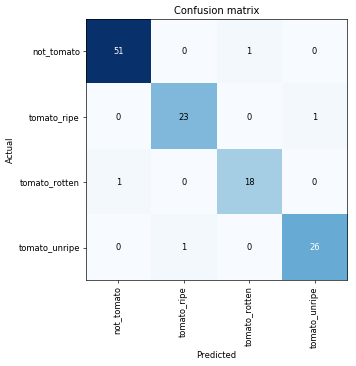

In [95]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Step 3: Unfreeze, train again

In [78]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


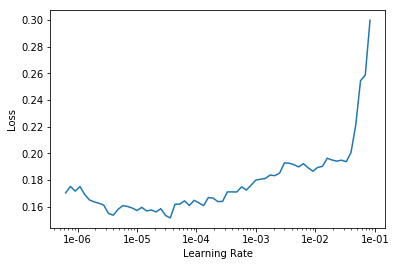

In [79]:
learn.recorder.plot()

In [0]:
learn.load(path_model/'resnet18_10_10epochs_err09')

In [85]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(2e-6,4e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.104339,0.163024,0.032787,00:30
1,0.116863,0.166550,0.032787,00:30


In [83]:
path_model.ls()

[PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet34_4epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet34_10epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/tmp.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet18_10epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet18_10_10epochs_err09.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/tmp2.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/rn18_stg1_1.pth')]

In [0]:
learn.save(path_model/'rn18_stg2_err03')

In [89]:
pip install torchsummary

In [92]:
from torchsummary import summary
summary(learn.model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,